<a href="https://colab.research.google.com/github/peterbabulik/QuantumPyTorch-Differentiable-Quantum-Circuits/blob/main/QuantumPyTorch_OTOCs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Setting up the Quantum System in PyTorch ---
Hamiltonian for 6 qubits on device 'cpu' created.

--- Running IDEAL (Noiseless) OTOC Simulation ---
Ideal simulation complete.

--- Running NOISY OTOC Simulation ---
Noisy simulation complete.


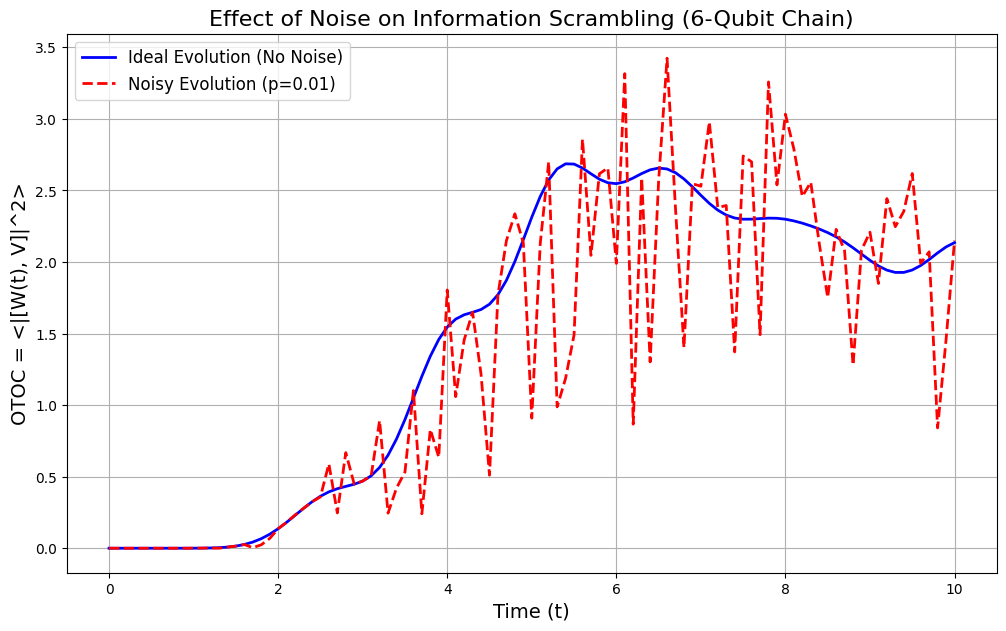

In [2]:
import torch
import matplotlib.pyplot as plt
import random

# ==============================================================================
# PART 1: System Definition in PyTorch
# ==============================================================================
print("--- Setting up the Quantum System in PyTorch ---")

# Use GPU if available, a key advantage of PyTorch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- System Parameters ---
N = 6          # Number of qubits. Keep small for exact simulation.
J = 1.0        # Coupling strength (interaction)
h = 0.5        # Transverse field strength (chaos)

# --- Pauli Matrices as PyTorch Tensors ---
X = torch.tensor([[0, 1], [1, 0]], dtype=torch.cfloat, device=device)
Z = torch.tensor([[1, 0], [0, -1]], dtype=torch.cfloat, device=device)
I = torch.eye(2, dtype=torch.cfloat, device=device)

def get_full_system_operator(op, i, num_qubits):
    """Creates the matrix for a single-qubit op acting on qubit 'i' in a larger system."""
    op_list = [I] * num_qubits
    op_list[i] = op
    full_op = op_list[0]
    for k in range(1, num_qubits):
        full_op = torch.kron(full_op, op_list[k])
    return full_op

# --- Construct the Hamiltonian Matrix ---
dim = 2**N
Hamiltonian = torch.zeros((dim, dim), dtype=torch.cfloat, device=device)

# Interaction terms: -J * Z_i * Z_{i+1}
for i in range(N - 1):
    z_i = get_full_system_operator(Z, i, N)
    z_j = get_full_system_operator(Z, i + 1, N)
    Hamiltonian -= J * (z_i @ z_j)

# Transverse field terms: -h * X_i
for i in range(N):
    x_i = get_full_system_operator(X, i, N)
    Hamiltonian -= h * x_i

print(f"Hamiltonian for {N} qubits on device '{device}' created.")

# ==============================================================================
# PART 2: OTOC Operators and Initial State
# ==============================================================================
# W and V are the "butterfly wing" and the "detector" to see how the effect spreads.
W = get_full_system_operator(X, 0, N)
V = get_full_system_operator(Z, N // 2, N)

# Initial state |00...0>
initial_state_ket = torch.zeros(dim, dtype=torch.cfloat, device=device)
initial_state_ket[0] = 1

# ==============================================================================
# PART 3: IDEAL SIMULATION (NO NOISE)
# ==============================================================================
print("\n--- Running IDEAL (Noiseless) OTOC Simulation ---")
time_steps = torch.linspace(0, 10, 101, device=device)
otoc_values_ideal = []

for t in time_steps:
    # U(t) = exp(-iHt). PyTorch's matrix_exp is the equivalent of scipy's expm.
    U_t = torch.matrix_exp(-1j * Hamiltonian * t)

    # Evolve W in the Heisenberg picture: W(t) = U†(t) W U(t)
    W_t = U_t.conj().T @ W @ U_t

    # Commutator: [W(t), V]
    commutator = (W_t @ V) - (V @ W_t)

    # OTOC: <Ψ| [W(t), V]† [W(t), V] |Ψ>
    # This is the squared norm of the state (commutator @ initial_state_ket)
    final_state = commutator @ initial_state_ket
    expectation_value = torch.real(torch.vdot(final_state, final_state))
    otoc_values_ideal.append(expectation_value.item())

print("Ideal simulation complete.")

# ==============================================================================
# PART 4: NOISY SIMULATION
# ==============================================================================
print("\n--- Running NOISY OTOC Simulation ---")
# To simulate noise, we must break the evolution into small steps (Trotterization)
# and apply noise after each step.

# --- Noise and Simulation Parameters ---
p_noise = 0.01  # 1% chance of a random error per qubit, per step
dt = 0.1        # Small time step for evolution
U_dt = torch.matrix_exp(-1j * Hamiltonian * dt) # Evolution operator for one small step

otoc_values_noisy = []

def apply_operator_noise(op, p_noise):
    """
    A simple noise model that probabilistically applies a random Pauli
    error (X, Y, or Z) to each qubit. This simulates decoherence on the operator.
    This is a heuristic but effective way to model noise in the Heisenberg picture.
    """
    for i in range(N):
        if torch.rand(1).item() < p_noise:
            # Pick a random Pauli operator to apply as an error
            pauli_error = get_full_system_operator(random.choice([X, Z]), i, N)
            # Apply the error channel: O -> P O P
            op = pauli_error @ op @ pauli_error
    return op

for t in time_steps:
    # Evolve W(t) step-by-step
    W_t_noisy = W.clone()
    num_steps = int(t / dt)

    for _ in range(num_steps):
        # 1. Evolve for one small step
        W_t_noisy = U_dt.conj().T @ W_t_noisy @ U_dt
        # 2. Apply the noise channel to the operator
        W_t_noisy = apply_operator_noise(W_t_noisy, p_noise)

    # Calculate OTOC with the noisy operator
    commutator_noisy = (W_t_noisy @ V) - (V @ W_t_noisy)
    final_state_noisy = commutator_noisy @ initial_state_ket
    expectation_value_noisy = torch.real(torch.vdot(final_state_noisy, final_state_noisy))
    otoc_values_noisy.append(expectation_value_noisy.item())

print("Noisy simulation complete.")

# ==============================================================================
# PART 5: Plot the Results for Comparison
# ==============================================================================
plt.figure(figsize=(12, 7))
plt.plot(time_steps.cpu().numpy(), otoc_values_ideal, 'b-', label='Ideal Evolution (No Noise)', linewidth=2)
plt.plot(time_steps.cpu().numpy(), otoc_values_noisy, 'r--', label=f'Noisy Evolution (p={p_noise})', linewidth=2)
plt.xlabel("Time (t)", fontsize=14)
plt.ylabel(f"OTOC = <|[W(t), V]|^2>", fontsize=14)
plt.title(f"Effect of Noise on Information Scrambling ({N}-Qubit Chain)", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


--- Running NOISY OTOC Simulation with Ensemble Averaging ---
Performing 50 separate noisy simulation runs...


  0%|          | 0/50 [00:00<?, ?it/s]

Noisy simulation and averaging complete.


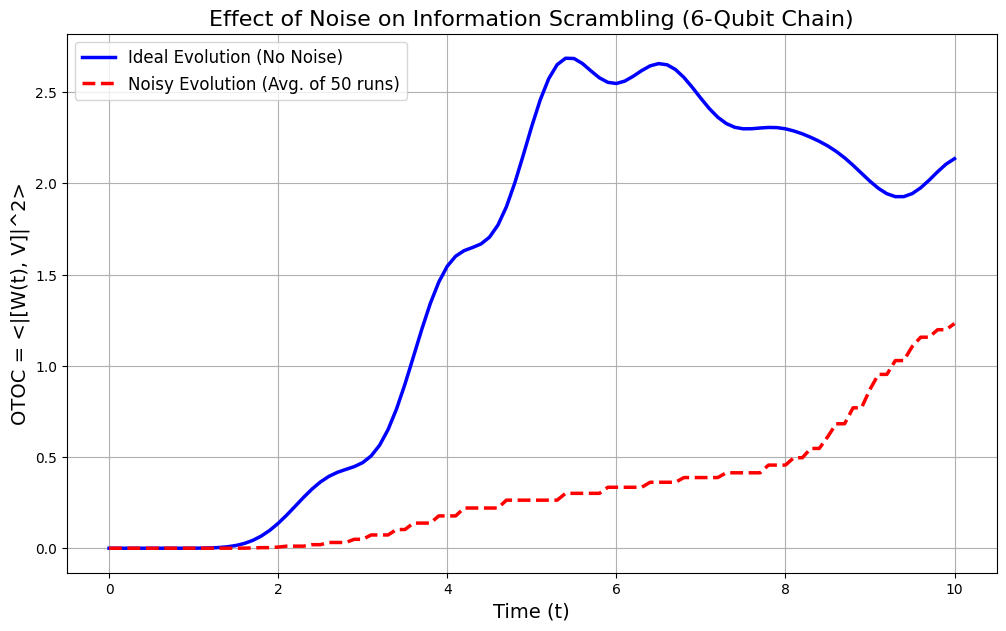

In [3]:
import torch
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm # Optional: for a nice progress bar

# ==============================================================================
# PART 1, 2, 3 are UNCHANGED...
# ==============================================================================
# (Assuming you have already run the previous code block in your notebook)

# ==============================================================================
# PART 4: NOISY SIMULATION WITH ENSEMBLE AVERAGING
# ==============================================================================
print("\n--- Running NOISY OTOC Simulation with Ensemble Averaging ---")

# --- Noise and Simulation Parameters ---
p_noise = 0.01
dt = 0.1
U_dt = torch.matrix_exp(-1j * Hamiltonian * dt)

# --- Averaging Parameters ---
num_runs = 50  # Number of random simulations to average over
all_noisy_runs = [] # Store the results of each run

print(f"Performing {num_runs} separate noisy simulation runs...")
for run_idx in tqdm(range(num_runs)): # tqdm provides a progress bar
    W_t_noisy = W.clone()
    otoc_values_single_run = []

    for t_idx, t in enumerate(time_steps):
        # We can simulate more efficiently by continuing from the previous time step
        if t_idx == 0:
            W_t_noisy = W.clone()
        else:
            # Evolve W(t) from the previous time step
            prev_t = time_steps[t_idx-1]
            num_steps = int((t - prev_t) / dt)
            for _ in range(num_steps):
                W_t_noisy = U_dt.conj().T @ W_t_noisy @ U_dt
                W_t_noisy = apply_operator_noise(W_t_noisy, p_noise)

        commutator_noisy = (W_t_noisy @ V) - (V @ W_t_noisy)
        final_state_noisy = commutator_noisy @ initial_state_ket
        expectation_value_noisy = torch.real(torch.vdot(final_state_noisy, final_state_noisy))
        otoc_values_single_run.append(expectation_value_noisy.item())

    all_noisy_runs.append(otoc_values_single_run)

# --- Calculate the average ---
# Convert list of lists to a tensor for easy averaging
all_noisy_runs_tensor = torch.tensor(all_noisy_runs)
otoc_values_noisy_avg = torch.mean(all_noisy_runs_tensor, dim=0)

print("Noisy simulation and averaging complete.")


# ==============================================================================
# PART 5: Plot the Averaged Results
# ==============================================================================
plt.figure(figsize=(12, 7))
plt.plot(time_steps.cpu().numpy(), otoc_values_ideal, 'b-', label='Ideal Evolution (No Noise)', linewidth=2.5)
# Plot the average of the noisy runs
plt.plot(time_steps.cpu().numpy(), otoc_values_noisy_avg.cpu().numpy(), 'r--', label=f'Noisy Evolution (Avg. of {num_runs} runs)', linewidth=2.5)
plt.xlabel("Time (t)", fontsize=14)
plt.ylabel(f"OTOC = <|[W(t), V]|^2>", fontsize=14)
plt.title(f"Effect of Noise on Information Scrambling ({N}-Qubit Chain)", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


--- Running Parameter Sweep for Noise Strength ---

--- Simulating for noise level p = 0.01 ---


p=0.01:   0%|          | 0/50 [00:00<?, ?it/s]


--- Simulating for noise level p = 0.05 ---


p=0.05:   0%|          | 0/50 [00:00<?, ?it/s]


--- Simulating for noise level p = 0.1 ---


p=0.1:   0%|          | 0/50 [00:00<?, ?it/s]


--- Simulating for noise level p = 0.2 ---


p=0.2:   0%|          | 0/50 [00:00<?, ?it/s]


--- Simulating for noise level p = 0.5 ---


p=0.5:   0%|          | 0/50 [00:00<?, ?it/s]


All simulations complete.


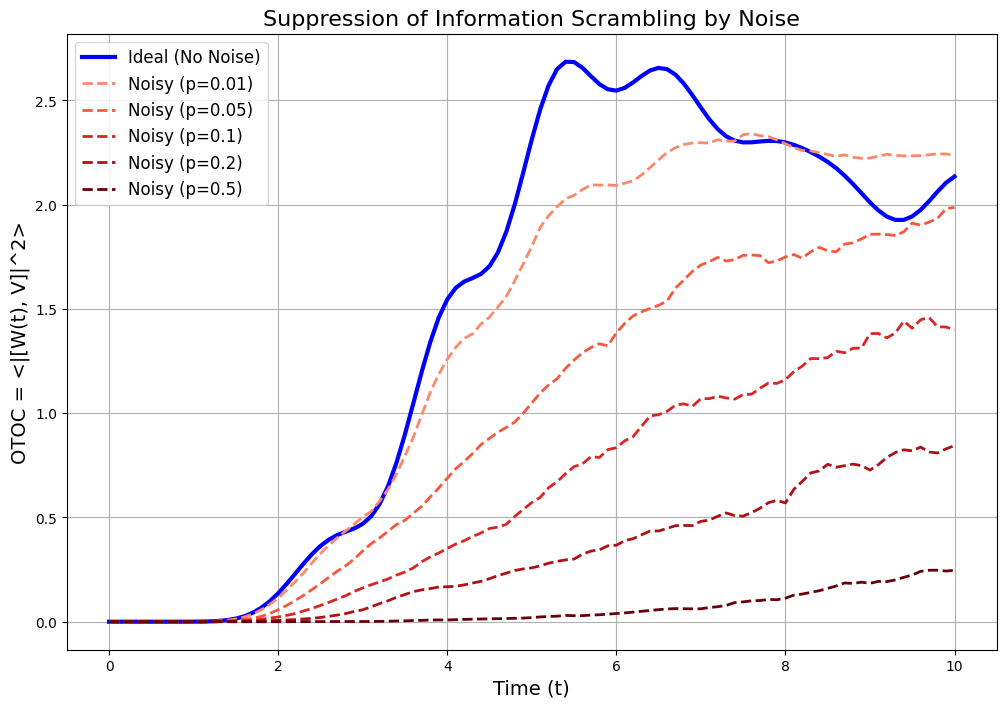

In [4]:
import torch
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm # Optional: for a nice progress bar
import numpy as np

# ==============================================================================
# PART 1, 2, 3 are UNCHANGED...
# ==============================================================================
# (We assume the Hamiltonian, operators, and the ideal simulation results
# from 'otoc_values_ideal' are already computed and in memory)

# ==============================================================================
# PART 4: PARAMETER SWEEP FOR NOISE STRENGTH
# ==============================================================================
print("\n--- Running Parameter Sweep for Noise Strength ---")

# --- Define the noise levels you want to test ---
# From 1% (0.01) up to 50% (0.50) noise probability
noise_levels = [0.01, 0.05, 0.1, 0.2, 0.5]

# --- Simulation Parameters ---
dt = 0.1
U_dt = torch.matrix_exp(-1j * Hamiltonian * dt)
num_runs = 50  # Keep the number of averages reasonable for speed

# --- Dictionary to store the results for each noise level ---
all_otoc_results = {}

# --- Master Loop: Iterate over each noise level ---
for p_noise in noise_levels:
    print(f"\n--- Simulating for noise level p = {p_noise} ---")

    all_noisy_runs = [] # Store results for this noise level's ensemble

    # --- Ensemble Average Loop (same as before) ---
    for run_idx in tqdm(range(num_runs), desc=f"p={p_noise}"):
        W_t_noisy = W.clone()
        otoc_values_single_run = []

        # --- Time Evolution Loop (same as before) ---
        for t_idx, t in enumerate(time_steps):
            if t_idx == 0:
                W_t_noisy = W.clone()
            else:
                prev_t = time_steps[t_idx-1]
                num_steps = int(round((t - prev_t).item() / dt))
                for _ in range(num_steps):
                    W_t_noisy = U_dt.conj().T @ W_t_noisy @ U_dt
                    # Crucially, pass the current p_noise to the function
                    W_t_noisy = apply_operator_noise(W_t_noisy, p_noise)

            commutator_noisy = (W_t_noisy @ V) - (V @ W_t_noisy)
            final_state_noisy = commutator_noisy @ initial_state_ket
            expectation_value_noisy = torch.real(torch.vdot(final_state_noisy, final_state_noisy))
            otoc_values_single_run.append(expectation_value_noisy.item())

        all_noisy_runs.append(otoc_values_single_run)

    # --- Calculate and store the average for this noise level ---
    all_noisy_runs_tensor = torch.tensor(all_noisy_runs)
    otoc_values_noisy_avg = torch.mean(all_noisy_runs_tensor, dim=0)
    all_otoc_results[p_noise] = otoc_values_noisy_avg

print("\nAll simulations complete.")

# ==============================================================================
# PART 5: Plot the Family of Curves
# ==============================================================================
plt.figure(figsize=(12, 8))

# Plot the ideal, noiseless case as a reference
plt.plot(time_steps.cpu().numpy(), otoc_values_ideal, 'b-', label='Ideal (No Noise)', linewidth=3)

# Use a colormap to show the progression of noise
colors = plt.cm.Reds(np.linspace(0.4, 1, len(noise_levels)))

# Plot the averaged result for each noise level
for i, (p_noise, otoc_curve) in enumerate(all_otoc_results.items()):
    plt.plot(time_steps.cpu().numpy(), otoc_curve.cpu().numpy(),
             linestyle='--',
             color=colors[i],
             label=f'Noisy (p={p_noise})',
             linewidth=2)

plt.xlabel("Time (t)", fontsize=14)
plt.ylabel(f"OTOC = <|[W(t), V]|^2>", fontsize=14)
plt.title(f"Suppression of Information Scrambling by Noise", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()